In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import pymc
from pymc import utils
from pymc.database import base

import glob

#plotting functions
import matplotlib.pyplot as plt
import matplotlib as mpl

variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']  
vn_title_dict = {'massbal':'Mass Balance',                                                                      
                 'precfactor':'Precipitation Factor',                                                              
                 'tempchange':'Temperature Bias',                                                               
                 'ddfsnow':'DDF Snow'}
vn_label_dict = {'massbal':'Mass balance\n[mwea]',                                                                      
                 'precfactor':'Precipitation factor\n[-]',                                                              
                 'tempchange':'Temperature bias\n[degC]',                                                               
                 'ddfsnow':'DDFsnow\n[mwe $degC^{-1} d^{-1}$]'}
metric_title_dict = {'Gelman-Rubin':'Gelman-Rubin Statistic',
                     'MC Error': 'Monte Carlo Error',
                     'Effective N': 'Effective Sample Size'}
metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']

suffix = '_trunc'
mcmc_output_netcdf_fp = '../MCMC_data/netcdf' + suffix + '/'
mcmc_output_figures_fp = '../MCMC_data/figures' + suffix + '/'
mcmc_output_tables_fp = '../MCMC_data/tables/'
mcmc_output_csv_fp = '../MCMC_data/csv' + suffix + '/'
mcmc_output_hist_fp = '../MCMC_data/hist' + suffix + '/'

In [4]:
def write_table2(iters, region='all', burn=0):
    '''
    Writes a csv table that lists mean MCMC assessment values for
    each glacier (represented by a netcdf file) for all glaciers at
    different chain lengths.

    Writes out the values of effective_n (autocorrelation with
    lag 100), Gelman-Rubin Statistic, MC_error.

    Parameters
    ----------
    region : int
        number of the glacier region (13, 14 or 15)
    iters : int
        Number of iterations associated with the Markov Chain
    burn : list of ints
        List of burn in values to plot for Gelman-Rubin stats

    Returns
    -------
    .csv files
        Saves tables to csv file.

    '''

    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']

    # find all netcdf files (representing glaciers)
    if region == 'all':
        regions = ['13', '14', '15']
        filelist = []
        for reg in regions:
            filelist.extend(glob.glob(mcmc_output_netcdf_fp + str(reg) + '*.nc'))
    else:
        filelist = glob.glob(mcmc_output_netcdf_fp + str(region) + '*.nc')
        
    # for testing
    filelist = filelist[0:10]

    for vn in variables:

        # create lists of each value
        glac_no = []
        effective_n_list = []
        gelman_rubin_list = []
        mc_error = []


        # iterate through each glacier
        for netcdf in filelist:
            print(netcdf)

           # try:
            # open dataset
            ds = xr.open_dataset(netcdf)

            # calculate metrics
            en = [effective_n(ds, vn=vn, iters=i, burn=burn) for i in iters]
            mc = [MC_error(ds, vn=vn, iters=i, burn=burn)[0] for i in iters]
            if len(ds.chain) > 1:
                gr = [gelman_rubin(ds, vn=vn, iters=i, burn=burn) for i in iters]

            # find values for this glacier and append to lists
            glac_no.append(netcdf[-11:-3])
            effective_n_list.append(en)
            # test if multiple chains exist
            if len(ds.chain) > 1:
                gelman_rubin_list.append(gr)

            # divide MC Error by the mean values
            print('ok')
            mean = np.mean(ds['mp_value'].sel(chain=n_chain, mp=vn).values)
            mc /= mean
            mc_error.append(mc)

            ds.close()

            #except:
                #print('Error, glacier: ', netcdf)
                #pass
            
        # do averaging operations
        print(effective_n_list)
        effective_n_list = np.mean(effective_n_list, axis=0)
        gelman_rubin_list = np.mean(gelman_rubin_list, axis=0)
        mc_error = np.mean(mc_error, axis=0)

        # create dataframe
        data = {'Iter': iters,
                'Effective N' : effective_n_list,
                'MC Error' : mc_error}
        if len(gelman_rubin_list) > 0:
            data['Gelman-Rubin'] = gelman_rubin_list
        df = pd.DataFrame(data)
        df.set_index('Iter', inplace=True)

        # save csv
        df.to_csv(mcmc_output_csv_fp + 'assessment_plot_' + str(region) + 'region_' +
                  str(iters) + 'iterations_' + str(burn) + 'burn_' + str(vn) + '.csv')

In [3]:
iters = np.arange(1000, 30000, 3000)
region = 'all'
burn = 0
write_table2(iters, region=region, burn=burn)

../MCMC_data/netcdf_trunc/13.54209.nc


NameError: name 'effective_n' is not defined

In [2]:
def plot_mc_results3(iters, region='all', burn=0, mean=False):
    """
    Plot gelman-rubin statistic, effective_n (autocorrelation with lag
    100) and markov chain error plots.

    Takes the output from the Markov Chain model and plots the results
    for the mass balance, temperature change, precipitation factor,
    and degree day factor of snow.  Also, outputs the plots associated
    with the model.

    Parameters
    ----------
    iters : int
        Number of iterations associated with the Markov Chain
    burn : list of ints
        List of burn in values to plot for Gelman-Rubin stats

    Returns
    -------
    .png files
        saves figure showing how assessment values change with
        number of mcmc iterations
    """

    # hard code some variable names (dirty solution)
    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']
    vn_title_dict = {'massbal':'Mass Balance',
                     'precfactor':'Precipitation Factor',
                     'tempchange':'Temperature Bias',
                     'ddfsnow':'DDF Snow'}
    metric_title_dict = {'Gelman-Rubin':'Gelman-Rubin Statistic',
                         'MC Error': 'Monte Carlo Error',
                         'Effective N': 'Effective Sample Size'}
    metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']


    if mean:
        # find mean values
        # find all netcdf files (representing glaciers)
        if region == 'all':
            regions = ['13', '14', '15']
            filelist = []
            for reg in regions:
                filelist.extend(glob.glob(mcmc_output_netcdf_fp + str(reg) + '*.nc'))
        else:
            filelist = glob.glob(mcmc_output_netcdf_fp + str(region) + '*.nc')

        mean_dict = {}

        for vn in variables:
            mean_dict[vn] = []

        for netcdf in filelist:

            print(netcdf)

            try:
                # open dataset
                ds = xr.open_dataset(netcdf)

                for vn in variables:
                    mean_dict[vn].append(abs(np.mean(ds['mp_value'].sel(chain=0, mp=vn).values)))

            except:
                print('Error: ', netcdf)
                pass

        # calculate total mean
        for vn in variables:
            mean_dict[vn] = np.mean(mean_dict[vn])



    # hard code font sizes
    ticks=10
    suptitle=14
    title=10
    titley = 1.05
    label=10
    plotline=2
    plotline2=1
    legend=10
    figsize=(6.5, 9)
    dpi=100
    hspace=0.6
    wspace=0.6
    sup_y = 0.97
    nrows=4
    ncols=3
    num_stds=1
    alpha = 0.7
    s_alpha = 0.5
    
    # bins and ticks
    bdict = {}
    tdict = {}

    plt.figure(figsize=figsize, dpi=dpi)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    m_len = len(metrics)
    v_len = len(variables)

    # create subplot for each variable
    for v_count, vn in enumerate(variables):

        df_dict = {}
        df_dict['Effective N'] = pd.read_csv(mcmc_output_csv_fp + vn + '_effective_n_df.csv')
        df_dict['MC Error'] = pd.read_csv(mcmc_output_csv_fp + vn + '_mc_error_df.csv')
        df_dict['Gelman-Rubin'] = pd.read_csv(mcmc_output_csv_fp + vn + '_gelman_rubin_df.csv')


        #create subplot for each metric
        for m_count, metric in enumerate(metrics):

            df = df_dict[metric]
            x = df.columns
            median = df.median().values
            u_quantile = df.quantile(q=0.95).values
            l_quantile = df.quantile(q=0.05).values

            print(median)
            print(u_quantile)
            print(l_quantile)

            # plot histogram
            ax = plt.subplot(nrows, ncols, m_len*v_count+m_count+1)

            ax.plot(x, median, alpha=alpha)

            #plot error region
            ax.fill_between(x, u_quantile, l_quantile, alpha=s_alpha)
            
            # niceties
            if v_count == 0:
                plt.title(metric_title_dict[metric], fontsize=title, y=titley)

            # axis labels
            if metric=='MC Error':
                ylabel = metric
            else:
                ylabel = metric + ' value'

            if m_count == 0:
                ax.set_ylabel(vn_title_dict[vn] + '\n\n' + ylabel, fontsize=label, labelpad=0)
            else:
                ax.set_ylabel(ylabel, fontsize=label)


In [29]:
regions = ['13', '14', '15']
filelist = []
for reg in regions:
    filelist.extend(glob.glob(mcmc_output_netcdf_fp + str(reg) + '*.nc'))

In [30]:
type(filelist)

list

In [31]:
len(filelist)

2999

In [25]:
def plot_mc_results3(iters, region='all', plot_res=1000, burn = 0):
    """
    Plot gelman-rubin statistic, effective_n (autocorrelation with lag
    100) and markov chain error plots.

    Takes the output from the Markov Chain model and plots the results
    for the mass balance, temperature change, precipitation factor,
    and degree day factor of snow.  Also, outputs the plots associated
    with the model.

    Parameters
    ----------
    netcdf_fn : str
        Netcdf of MCMC methods with chains of model parameters
    iters : int
        Number of iterations associated with the Markov Chain
    burn : list of ints
        List of burn in values to plot for Gelman-Rubin stats
    plot_res: int
        Interval of points for which GR and MCerror statistic are calculated.
        (Lower value leads to higher plot resolution)
    glacier_RGIId_float : str
    precfactor_mu : float
        Mean of precipitation factor (default assigned from input)
    tempchange_mu : float
        Mean of temperature change (default assigned from input)
    ddfsnow_mu : float
        Mean of degree day factor of snow (default assigned from input)

    Returns
    -------
    .png files
        Saves two figures of (1) trace, histogram, and autocorrelation, and (2) pair-wise scatter plots.
    """
    
    # hard code some variable names (dirty solution)
    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']
    vn_title_dict = {'massbal':'Mass Balance',
                     'precfactor':'Precipitation Factor',
                     'tempchange':'Temperature Bias',
                     'ddfsnow':'DDF Snow'}
    metric_title_dict = {'Gelman-Rubin':'Gelman-Rubin Statistic',
                         'MC Error': 'Monte Carlo Error',
                         'Effective N': 'Effective Sample Size'}
    metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']

    # hard code font sizes
    ticks=10
    suptitle=14
    title=10
    titley = 1.05
    label=10
    plotline=2
    plotline2=1
    legend=10
    figsize=(6.5, 9)
    dpi=100
    hspace=0.6
    wspace=0.6
    sup_y = 0.97
    nrows=4
    ncols=3
    num_stds=1
    alpha = 0.7
    s_alpha = 0.5

    # bins and ticks
    bdict = {}
    tdict = {}


    plt.figure(figsize=figsize, dpi=dpi)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    
    m_len = len(metrics)
    v_len = len(variables)
    
    # create subplot for each variable
    for v_count, vn in enumerate(variables):

        df = pd.read_csv(mcmc_output_csv_fp + 'assessment_plot_' +
                         str(region) + 'region_' + str(burn) +
                         'burn_' + str(vn) + '.csv')
    
        #create subplot for each metric
        for m_count, metric in enumerate(metrics):
            
            x = df['Iter']
            mean = df[metric + ' mean']
            std = df[metric + ' std']
            
            # plot histogram
            ax = plt.subplot(nrows, ncols, m_len*v_count+m_count+1)
            
            ax.plot(x, mean, alpha=alpha)
            
            #plot error region
            ax.fill_between(x, mean-(num_stds*std),
                     mean+(num_stds*std), alpha=s_alpha)
            
            # niceties
            if v_count == 0:
                plt.title(metric_title_dict[metric], fontsize=title, y=titley)

            # axis labels
            if metric=='MC Error':
                ylabel = metric
            else:
                ylabel = metric + ' value'
                
            if m_count == 0:
                ax.set_ylabel(vn_title_dict[vn] + '\n\n' + ylabel, fontsize=label, labelpad=0)
            else:
                ax.set_ylabel(ylabel, fontsize=label)



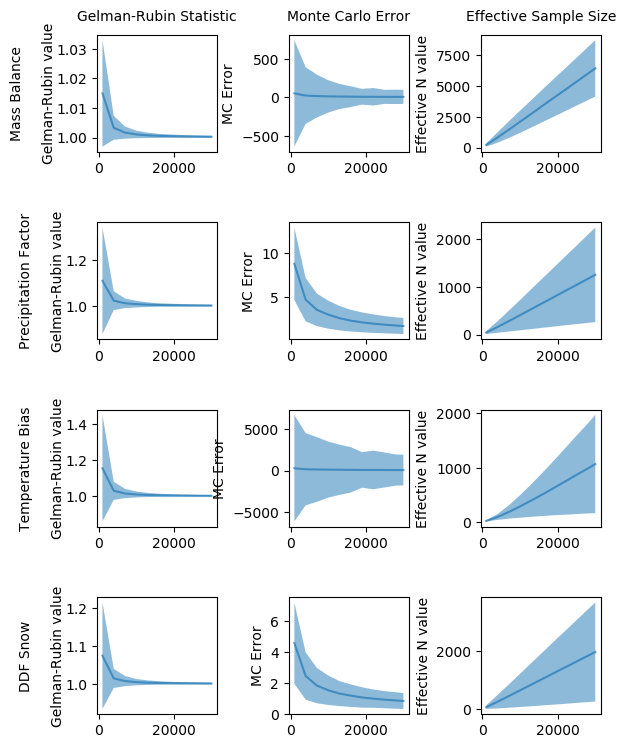

In [26]:
iters = np.arange(1000, 30000, 3000)
region = 'all'
burn = 0
plot_mc_results3(iters, region=region, burn=burn)

In [4]:
# create subplot for each variable
for v_count, vn in enumerate(variables):

    df_dict = {}
    df_dict['Effective N'] = pd.read_csv(mcmc_output_csv_fp + vn + '_effective_n_df.csv')
    df_dict['MC Error'] = pd.read_csv(mcmc_output_csv_fp + vn + '_mc_error_df.csv')
    df_dict['Gelman-Rubin'] = pd.read_csv(mcmc_output_csv_fp + vn + '_gelman_rubin_df.csv')


In [16]:
df_dict['Effective N'].

,1000,4000,7000,10000,13000,16000,19000,22000,25000,28000,30000
0,80,271,423,635,897,1120,1359,1589,1818,2079,2220
1,47,225,404,644,896,1135,1364,1646,1826,2042,2164
2,120,531,972,1457,1809,2310,2728,3039,3406,3806,3883
3,13,86,231,326,437,544,669,750,856,913,992
4,94,197,374,631,838,949,1165,1358,1608,1867,2020
5,43,145,265,393,480,623,465,594,777,893,959
6,60,295,546,764,957,1120,1215,1503,1740,1887,2052
7,281,453,1142,1664,2151,2620,3165,3668,4183,4818,5074
8,64,350,535,772,1024,1306,1649,1819,2095,2324,2533
9,222,687,1142,1726,2210,2694,3230,3781,4224,4579,4885


In [30]:
for vn in variables:
        print(vn)
        mc_error_df = pd.read_csv(mcmc_output_csv_fp + vn + '_mc_error_df.csv').set_index('Unnamed: 0')
        mean_df = pd.read_csv(mcmc_output_csv_fp + vn + '_mean.csv').set_index('Unnamed: 0')
        normalized_mc_error_df = mc_error_df * 100 / mean_df
        normalized_mc_error_df.to_csv(mcmc_output_csv_fp + vn + '_normalized_mc_error_df.csv')

massbal
precfactor
tempchange
ddfsnow


In [27]:
normalized_mc_error_df = mc_error_df * 100 / mean_df

In [28]:
normalized_mc_error_df.to_csv(mcmc_output_csv_fp + 'normalized_massbal_mc_error_df.csv')

,1000,4000,7000,10000,13000,16000,19000,22000,25000,28000,30000
Unnamed: 0,,,,,,,,,,,
13.54209,40.923392,11.265820,4.659659,7.666967,8.386437,5.739907,5.415462,4.026843,3.014359,3.236937,2.817092
13.14191,43.411228,16.083401,9.360850,10.383162,7.147386,4.560340,4.736179,6.034252,3.087746,5.554773,4.497916
13.42130,9.087717,4.345675,2.082700,1.254597,1.261067,1.503682,2.224441,1.862169,1.805384,1.946431,2.332799
13.41737,6.035646,2.547071,1.459377,1.447253,1.437143,1.393977,1.154017,0.671448,0.782039,1.031030,0.974546
13.29374,68.059556,54.227389,38.355467,39.686949,39.618905,43.152712,27.633238,21.135553,21.833723,25.015363,23.827840
13.26968,4.594372,2.038553,1.176661,0.670486,1.547944,1.731214,0.446606,0.747591,0.674597,0.589086,0.841039
13.28996,48.148531,8.329301,13.169498,10.371442,5.787124,8.557155,8.119970,8.032379,4.118719,4.326064,4.806332
13.40300,3.844426,2.680228,1.834985,1.374140,0.940734,1.117388,0.932425,0.732621,0.840868,0.552700,0.659317
13.41885,774.973950,44.325948,46.352823,33.529349,25.899929,5.476653,17.801534,27.708894,17.543696,19.283459,16.779386


In [ ]:
    #create subplot for each metric
    for m_count, metric in enumerate(metrics):

        # create subplot for each variable
        for v_count, vn in enumerate(variables):

            df = vn_df_dict[vn]

            # plot histogram
            ax = plt.subplot(v_len, m_len, m_len*v_count+m_count+1)
            ax2 = ax.twinx()

            # compute histogram and change to percentage of glaciers
            hist, bins = np.histogram(a=df[metric], bins=bdict[metric + ' ' + vn])
            hist = hist * 100.0 / hist.sum()

            # plot histogram
            ax.bar(x=bins[1:], height=hist, width=(bins[1]-bins[0]), align='center',
                   alpha=.4, edgecolor='black', color='#0504aa')

            # create uniform bins based on metric
            ax.set_yticks(tdict[metric])

            # find cumulative percentage and plot it
            cum_hist = [hist[0:i].sum() for i in range(len(hist))]

            # find 5 % point or 95 % point
            if metric=='Effective N':
                percent = 5
            else:
                percent = 95
            index = 0
            for point in cum_hist:
                if point < percent:
                    index += 1

            ax2.plot(bins[:-1], cum_hist, color='#ff6600',
                     linewidth=plotline, label='Cumulative %')
            ax2.set_yticks(np.arange(0, 110, 20))

            ax2.plot([bins[index], bins[index]],[cum_hist[index], 0], color='black',
                     linewidth=plotline2)

            # set tick sizes
            ax.tick_params(labelsize=ticks)
            ax2.tick_params(labelsize=ticks)

            ax2.set_ylim(0, 100)
            #ax.set_xlim(bins[0], bins[-1])

            # niceties
            if v_count == 0:
                plt.title(metric_title_dict[metric], fontsize=title, y=titley)

            # axis labels
            if m_count == 0:
                ax.set_ylabel(vn_title_dict[vn] + '\n\n% of Glaciers', fontsize=label, labelpad=0)
            if m_count == 2:
                ax2.set_ylabel('Cumulative %', fontsize=label, rotation = 270, labelpad=10)
            if metric=='MC Error':
                ax.set_xlabel(metric + ' (% of mean)', fontsize=label)
            else:
                ax.set_xlabel(metric + ' value', fontsize=label)

            # legend
            #if v_count==3 and m_count==2:
                #ax2.legend(loc='best', fontsize=legend)

In [ ]:
variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']
metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']
iters = np.arange(1000, 30000, 3000)

# read csv filesdata
data = {}
for vn in variables:
    for metric in metrics:
        iters = iters
        mean = []
        std = []
        for i in iters:
            df = pd.read_csv(mcmc_output_csv_fp + 'region' +
                             str(region) + '_' + str(i) +
                             'iterations_' + str(burn) + 'burn_' +
                             str(vn) + '.csv')
            mean.append(np.mean(df[metric].values))
            std.append(np.std(df[metric].values))
        d = {'iters': iters}
        pd.DataFrame()
        data[()]
            
        
for vn in variables:
    for i in iters:
        iters_df_dict = {}
        iters_df_dict[i] = pd.read_csv(mcmc_output_csv_fp + 'region' +
                                         str(region) + '_' + str(i) +
                                         'iterations_' + str(burn) + 'burn_' +
                                         str(vn) + '.csv')
    vn_df_dict[vn] = iters_df_dict

In [34]:
region = 'all'
vn = 'massbal'
i = 1000
burn = 0
df = pd.read_csv(mcmc_output_csv_fp + 'region' +
            str(region) + '_' + str(i) +
            'iterations_' + str(burn) + 'burn_' +
            str(vn) + '.csv')

In [41]:
np.std(df['MC Error'].values)

0.4499681954176562

In [31]:
for m_count, metric in enumerate(metrics):                                                                      
                                                                                                                       

    df = df_dict[metric].drop('Unnamed: 0', 1)                                                                  
    if metric == 'MC Error' and (vn == 'massbal' or vn == 'tempchange'):                                        
        df = df_dict['normalized ' + metric].drop('Unnamed: 0', 1)

In [40]:
df = pd.read_csv(mcmc_output_csv_fp + 'massbal' + '_normalized_mc_error_df.csv').drop('Unnamed: 0', 1)

In [53]:
x = df.columns.values

In [57]:
x.astype(int)

array([ 1000,  4000,  7000, 10000, 13000, 16000, 19000, 22000, 25000,
       28000, 30000])